In [1]:
from quimb.tensor import MatrixProductOperator, DMRG2
import numpy as np
import quimb as qu
import quimb.tensor as qtn

/Users/siddhimali/Library/Python/3.9/lib/python/site-packages/cotengra/hyperoptimizers/hyper.py:57: UserWarning: Couldn't find `optuna`, `cmaes`, `baytune (btb)`, `chocolate`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/siddhimali/Library/Python/3.9/lib/python/site-packages/cotengra/hyperoptimizers/hyper.py:39: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/siddhimali/Library/Python/3.9/lib/python/site-packages/cotengra/hyperoptimizers/hyper.py:76: UserWarning: Couldn't find `optuna`, `cmaes`, `baytune (btb)`, `chocolate`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


In [2]:
def construct_ssh_mpo(L, t1, t2):
    """Construct the SSH model as an MPO from scratch.

    Parameters:
    L (int): Number of unit cells (total sites = 2L).
    t1 (float): Intra-cell hopping.
    t2 (float): Inter-cell hopping.

    Returns:
    MPO: The MPO representation of the SSH Hamiltonian.
    """
    d = 2  # Local Hilbert space dimension (spinless fermion per site)
    
    # Fermionic creation and annihilation operators
    c_dag = np.array([[0, 1], [0, 0]], dtype=complex)  # c†
    c = np.array([[0, 0], [1, 0]], dtype=complex)  # c
    I = np.eye(2, dtype=complex)  # Identity

    # MPO bond dimension (SSH model has nearest-neighbor terms)
    D = 3  
    
    # Define empty list for MPO tensors
    mpo_tensors = []

    # Construct tensors for each site
    for i in range(2 * L):  # Total sites = 2L
        W = np.zeros((D, D, d, d), dtype=complex)  # (left bond, right bond, physical, physical)
        
        # Identity propagation
        W[0, 0] = I  

        # Hopping term (t1 or t2)
        if i % 2 == 0:  # A-site
            W[0, 1] = c_dag
            W[2, 0] = c
        else:  # B-site
            W[1, 2] = t1 * c
            W[1, 0] = t1 * c_dag
            if i < 2 * L - 1:  # Avoid out-of-bounds for last site
                W[2, 0] = t2 * c_dag
                W[2, 1] = t2 * c

        # Last site correction
        if i == 2 * L - 1:
            W[0, 0] = I
            W[1, 0] = t1 * c_dag
            W[2, 0] = t2 * c_dag

        mpo_tensors.append(W)
    
    # Convert to MPO object
    return qtn.MatrixProductOperator(mpo_tensors)

# Example: Construct SSH MPO for L = 10, t1 = 1.0, t2 = 0.8
L = 10
t1 = 1.0
t2 = 0.8
H_mpo = construct_ssh_mpo(L, t1, t2)


In [3]:
dmrg = DMRG2(H_mpo)

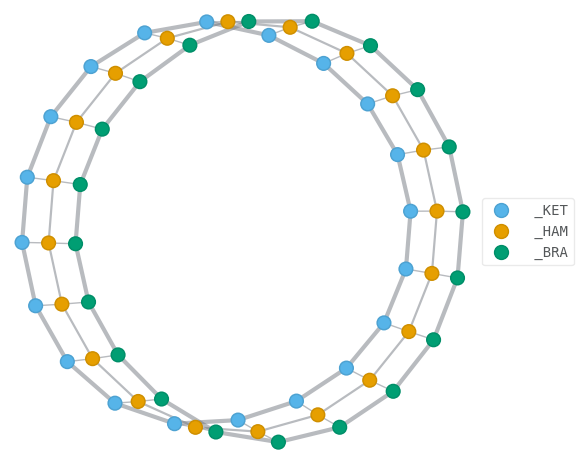

In [4]:
dmrg.TN_energy.draw(color=['_KET', '_HAM', '_BRA'])  # might be slow as uses force repulsion

In [5]:
dmrg.solve(max_sweeps=4, verbosity=1, cutoffs=1e-6)

1, R, max_bond=(8/8), cutoff:1e-06


100%|###########################################| 20/20 [00:02<00:00,  7.16it/s]

Energy: (0.564811808165291+0.18824241081543872j) ... not converged.
2, R, max_bond=(8/16), cutoff:1e-06



100%|###########################################| 20/20 [00:02<00:00,  7.48it/s]

Energy: (0.5628387697113689+0.19125461550684825j) ... not converged.
3, R, max_bond=(16/32), cutoff:1e-06



100%|###########################################| 20/20 [00:03<00:00,  5.84it/s]

Energy: (0.5628389353581812+0.19125464447935853j) ... converged!


True

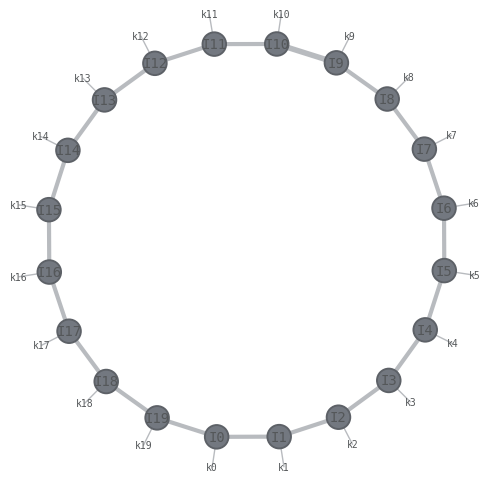

In [6]:
dmrg.state.draw()

In [8]:
def compute_berry_phase(mps, L, k_points=100):
    """
    Compute the Berry phase (Zak phase) of an MPS state.
    
    Parameters:
    mps (qtn.MatrixProductState): The ground state MPS.
    L (int): The number of unit cells (total sites = 2L).
    k_points (int): Number of k-points for discretization.
    
    Returns:
    float: The Berry phase in radians.
    """
    # Define momentum grid in the Brillouin zone [-π, π]
    k_vals = np.linspace(-np.pi, np.pi, k_points, endpoint=False)
    dk = k_vals[1] - k_vals[0]  # Discrete step in k

    # Store overlaps between consecutive momentum states
    phase_factors = []

    # Compute overlaps ⟨ψ(k) | ψ(k+dk)⟩
    for i in range(len(k_vals) - 1):
        k1, k2 = k_vals[i], k_vals[i+1]

        # Apply Fourier transformation to get |ψ_k⟩
        psi_k1 = mps.copy()
        psi_k2 = mps.copy()

        # Apply phase e^(i k n) to each site n
        for site in range(2 * L):  # Total sites
            psi_k1[site].modify(data=psi_k1[site].data * np.exp(1j * k1 * site))
            psi_k2[site].modify(data=psi_k2[site].data * np.exp(1j * k2 * site))

        # Normalize the states
        psi_k1 /= psi_k1.norm()
        psi_k2 /= psi_k2.norm()

        # Compute overlap ⟨ψ(k) | ψ(k+dk)⟩
        overlap = psi_k1.H @ psi_k2
        phase_factors.append(overlap)

    # Compute the Berry phase as the product of overlaps
    berry_phase = np.angle(np.prod(phase_factors))  # Sum of phase angles

    return berry_phase

# Example usage
L = 10  # Number of unit cells
berry_phase = compute_berry_phase(H_mpo, L)
print(f"Berry Phase: {berry_phase:.4f} radians")


Berry Phase: 0.6283 radians
